# Cluster the mission statements of the nonprofits

Take the not-for-profit organization name and/or their mission statement from  Form 990/Form 990N data and identify natural groupings to help categorize them.

For this, we only used charities in GA, IL, MI, MT, and NY. (And already it takes a while to run.)

## Setup

In [1]:
%matplotlib inline
import csv
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

plt.rcParams['figure.figsize'] = (12, 7)

## Load the data
Map the organization names and (if they exist) mission statements to the Nonprofit's Employer ID Number (EIN). The goal is to group similar organizations.

In [226]:
# Go through all of the entries from all of the Form 990 tax forms.
# We want
#  - the EIN number (to identify the business)
#  - their business name (because sometimes that's all there is)
#  - their mission statement(s)
state_paths = glob.glob(os.path.join('data', 'form990', '*'))
nfp_names = {}  # Map the EIN number to the business name
missions = {}  # Map the EIN number to the mission statement(s)

# We will also want a future lookup of state + city --> EIN
ein_state_city = {}

def get_city(path):
    return os.path.basename(path)[:-4]

for dirname in state_paths:
    cities_990 = glob.glob(os.path.join(dirname, '*'))
    # Set up to collect all of the EINs in a given state and city.
    state_abbr = os.path.basename(dirname)
    ein_state_city[state_abbr] = {}

    for fname in cities_990:
        city = get_city(fname)
        ein_state_city[state_abbr][city] = []
        with open(fname) as infile:
            rdr = csv.reader(infile, delimiter='\t')
            nfp_names_etc = [
                (row[0], row[2], row[27], row[-1], row[-2])
                for row in rdr
            ]
            nfp_names.update(dict(entry[:2] for entry in nfp_names_etc))
            missions.update(dict(
                    (entry[0], '  '.join(set(entry[1:])))  # remove duplicates
                    for entry in nfp_names_etc
            ))
            ein_state_city[state_abbr][city].append(nfp_names_etc[0])

## See a few of the entries

In [82]:
counter = 0
iterator = iter(missions.items())
while counter < 5:
    print(next(iterator))
    counter += 1

('', '')
('166050723', '  OTHER NON-ALLOCABLE EXPENSE -  WOLKERNIE CO-TR UA CHAR')
('201873050', '  X  MONTANA POLICE PROTECTIVE ASSOCIATION FOUNDATION INC')
('112368182', "New Community Cinema Club Inc DBA Cinema Arts Centre  Victor Skolnick and Charlotte Sky founded the Centre in 1973 to create an alternative to the mainstream movie theaters and media that were then available on Long Island. The Centre presents an international array of films that explore diverse social, historical and cultural realities, and uses the power of film to expand the awareness and consciousness of the Long Island Community. The Centre operates in Huntington, New York. It is supported primarily through ticket sales, membership dues, and contribution and grant revenue.The Centre's core values are:Artistry: Creating a place where Long Islanders can experience the same level of cinematic artistry as audiences in major cities like New York, San Francisco, Los Angeles, Paris and Berlin.Egalitarianism: Making th

## Continue by loading the 990N data

In [228]:
# Also go through the Form 990N tax forms.
# We want
#  - the EIN number (to identify the business)
#  - their business name (there is no mission statement)
state_paths = glob.glob(os.path.join('data', 'form990N', '*'))
for dirname in state_paths:
    state_abbr = os.path.basename(dirname)
    if state_abbr not in ein_state_city:
        ein_state_city[state_abbr] = {}
    cities_990 = glob.glob(os.path.join(dirname, '*'))
    for fname in cities_990:
        city = get_city(fname)
        if city not in ein_state_city[state_abbr]:
            ein_state_city[state_abbr][city] = []
        with open(fname) as infile:
            rdr = csv.reader(infile, delimiter='\t')
            ein_to_name = dict((row[0], row[2]) for row in rdr)
            nfp_names.update(ein_to_name)
            # Missions too (use the name as the mission for 990Ns)...
            missions.update(ein_to_name)
            ein_state_city[state_abbr][city].extend(ein_to_name.keys())


del missions['']  # There was an empty EIN somewhere

## Group the Not-for-Profits by mission
1. Tokenize using the NLTK and scikit-learn text tools
2. Cluster using K-means
3. Look at what the clusters are and try and distinguish common features

In [83]:
# The tokenizer will split out words to help autogenerate
# 'tags' for the Nonprofit names/missions using the
# Natural Language Toolkit
custom_stopwords = stopwords.words('English') + [
    'x', 'association', 'club', 'institute', 'consortium', 'group',
    'incorporated', 'inc', 'llc', 'l3c', '&'
]
def tokenize(
        phrase,
        space_or_punct=re.compile("[\s,;:!\.]+"),
        stemmer=PorterStemmer(),
        stopwords=stopwords.words("English")):
    split_phrase = space_or_punct.split(phrase.lower())
    return set(stemmer.stem(word)
               for word in split_phrase
               if word not in stopwords and len(word))

In [55]:
#from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import k_means
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
sorted_nfps = sorted(missions.keys())
token_matrix = HashingVectorizer(
    tokenizer=tokenize,
    n_features=150
).transform([missions[ein] for ein in sorted_nfps])

### Try multiple cluster sizes to find some categorization that levels off
(This takes a really long time.)

In [86]:
mean_distances = {}
for k in range(5, 13):
    print('cluster size:', k)
    mean_distances[k] = k_means(token_matrix, k)[-1]

cluster size: 5
cluster size: 6
cluster size: 7
cluster size: 8
cluster size: 9
cluster size: 10
cluster size: 11
cluster size: 12


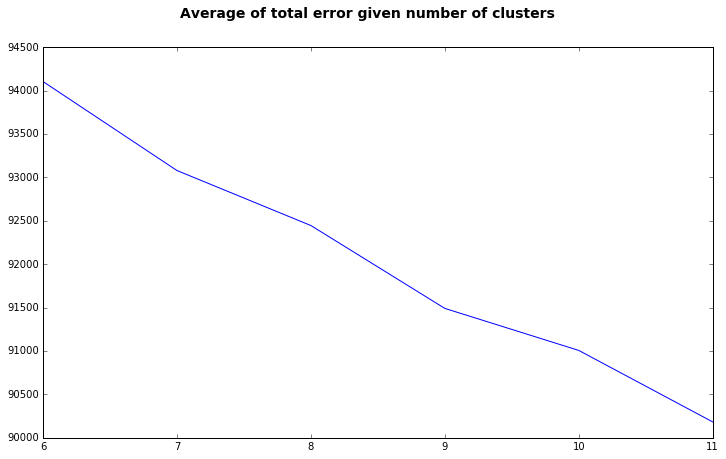

In [87]:
ax = plt.plot(keys, [mean_distances[k] for k in keys])
__ = plt.suptitle(
    'Average of total error given number of clusters',
    fontweight='bold', fontsize=14)

### Well, nothing bottomed out.
Just pick a big number of clusters. Maybe I'll run the loop with more clusters later, but it takes over an hour.

In [88]:
num_clusters = 12
centers, labels, inertia =  k_means(token_matrix, num_clusters)

In [93]:
clustered_missions = {}
for label, ein in zip(labels, sorted_nfps):
    if label not in clustered_missions:
        clustered_missions[label] = [missions[ein]]
    else:
        clustered_missions[label].append(missions[ein])

word_counts = {}
for label, stmts in clustered_missions.items():
    print('~' * 20)
    print(label)
    print(len(stmts))
    word_counts[label] = Counter(
        [word.lower() for stmt in stmts for word in stmt.split()
         if word.lower() not in custom_stopwords]
    )
    print('\n'.join(stmts[:5]))
    print(word_counts[label].most_common(25)[-20:])

~~~~~~~~~~~~~~~~~~~~
0
2326
GREATER ROCHELLE AREA CHRISTIAN EDUCATORS
PTO GEORGIA CONGRESS TATE PRIMARY
A NEW START ON LIFE
DEPARTMENT OF NEW YORK LADIES AUXILIARY TO THE VETERANS OF
DEPARTMENT OF NEW YORK LADIES AUXILIARY TO THE VETERANS OF
[('free', 480), ('accepted', 472), ('georgia', 322), ('teachers', 305), ('parents', 300), ('ladies', 239), ('area', 223), ('auxiliary', 213), ('illinois', 208), ('veterans', 195), ('michigan', 188), ('students', 135), ('foreign', 118), ('dept', 118), ('wars', 118), ('us', 95), ('department', 89), ('montana', 85), ('ptsa', 84), ('fund', 78)]
~~~~~~~~~~~~~~~~~~~~
1
7946
  MAINE JAZZ CAMP  X
  X  SIETAR USA
  ADIRONDACK CENTER FOR WRITING  X
  MILLBROOK CSD EDUCATION FOUNDATION  X
  X  3 ANGELS BROADCASTING MESSENGERS
[('society', 384), ('housing', 380), ('fund', 372), ('county', 366), ('support', 360), ('provide', 289), ('organization', 280), ('public', 277), ('corporation', 263), ('youth', 254), ('development', 250), ('educational', 240), ('library'

## Apply tags, informed by the clustering

Not sure whether the time it took to cluster was worth it.
We did get things like music grouped together, financial/scholarship organizations together, and types of medical organizations grouped together, but I think I could have figured that out without clustering. The top-scoring tokens help with choosing phrases to match to the tags, thought.

From comments in the [pitch document][bundlekind-pitch]:

>We should align to an agreed upon core set of issues across the network, and stick to that. We've sort of been trying to align to the issues Code Corps has in their tool, but we should also talk to groups like Brand New Congress, Issue Voter, and any others with issue categories.


[bundlekind-pitch]: https://docs.google.com/document/d/1KEC3JhaJlIf7heexA8LtSaCuTGABYtvu_iRKC-Y0SLk

In [237]:
tags = dict(
    religious=['christ', 'jesus', 'prayer', 'god', 'church', 'pastor', 'mission', 'mosque',
               'temple', 'abraham', 'faith', 'bibl', 'spiritual', 'meditation',
               'minist', 'jewish', 'hebrew', 'salvation', 'divin', 'holy', 'eternity',
               'catholic', 'sikh', 'buddhist', 'hindu', 'bahai', 'islam', 'hope', 'jain', 'atheis'],
    youth=['youth', 'child', 'kid', 'tot', 'camp', 'campus', 'play', 'motiv', 'girl',
           'boy', 'student', 'scout', '4h', 'mentor', 'minor', 'troop'],
    family=['family', 'husband', 'wive', 'wife', 'parent', 'marriage'],
    women=['women', 'woman', 'girl', 'ladies', 'daughter'],
    gender=['gender', 'lgbt'],
    sports=['sport', 'ath', 'fitness', 'hike', 'hiking', 'ball', 'little league', 'pop warner',
            'ski', 'skate', 'snow', 'rifle', 'hunt', 'fish', 'run', 'cycle', 'bike', 'swim',
            'equestrian', 'ice rink', 'tennis', 'hunt', 'bowling', 'gymnast', 'judo', 'soccer',
            'karate', 'kung', 'taek', 'yoga', 'rodeo', 'wrestl', 'double dutch',
            'lacrosse', 'budo', 'backpack'],
    education=['teach', 'educ', 'pta', 'learn', 'student', 'study', 'school',
               'grade', 'alumni', 'university', 'college', 'school', 'institute',
               'booster', 'scholar', 'academy', 'elementary',
               'literacy', 'library', 'toastmaster', 'debate', 'museum', 'planetarium'],
    health=['health', 'counseling', 'mental', 'medical', 'medicine', 'hospital', 'clinic',
            'doctor', 'nurse', 'parenthood', 'cancer', 'hospice', 'terminal', 'care',
            'red cross'],
    arts=['art', 'perform', 'choir', 'sing', 'choral', 'adelines', 'symphony',
          'orchest', 'danc', 'choreogra',
          'music', 'jazz', 'band', 'marching', 'ensemble', 'theat', 'movie',
          'film', 'cinema', 'poetry', 'poem', 'writ', 'paint', 'sculpt', 'ensemble',
          'cultural', 'literature', 'opera', 'broadway', 'production'],
    employment=['train', 'vocation', 'job', 'work', 'skill'],
    nature=['nature', 'beautiful', 'animal', 'pet', 'horse', 'rescue', 'marine',
            'green', 'nature', 'tree','arbor', 'preserve', 'conserv', 'wolf',
            'eagle', 'outdoor', 'beach', 'trail', 'endangered', 'coast',
            'garden', 'park', 'mountain', 'lake', 'sanctuary', 'energy',
            'canal', 'creek'],
    rehabilitation=['prison', 'rehab', 'transitional house'],
    addiction=['addiction', 'drug', 'alcohol', 'aaa', 'overdose'],
    funding=['fund', 'foundation', 'charit', 'trust', 'invest', 'income', 'scholarship',
             'fellowship', 'financ', 'capital', 'gift'],
    media=['media', 'broadcast', 'telev', 'tv', 'radio', 'news', 'speech', 'publish',
           'publicat'],
    military=['veteran', 'vets', 'vfw', 'war', 'soldier', 'military', 'army', 'navy', 'guard',
              'force', 'squadron', 'battalion', 'corps'],
    elderly=['senior', 'home care', 'elderly', 'adult', 'retire', 'dementia', 'grandma', 'grandpa'],
    poverty=['poverty', 'poor', 'homeless', 'kitchen', 'food', 'pantry', 'low income',
             'habitat', 'thrift', 'goodwill', 'charity', 'need'],
    professional=['union', 'worker', 'nurse', 'doctor', 'police', 'sheriff', 'fire',
                  'ist', 'bar ass', 'cemetery', 'pilot', 'commerce', 'employee',
                  'engineer', 'users', 'development', 'trade', 'barber', 'cosmetic',
                  'opportun', 'management', 'economic'],
    advocacy=['lawyer', 'legal', 'defense', 'liberty', 'liberties', 'civil'],
    social=['daughter', 'son', 'brother', 'sister', 'men', 'women',
            'riders', 'motorcy', 'deaf', 'blind', 'immigr', 'refugee', 'association', 'assn',
           'family', 'community', 'neighbor', 'order', ],
    # Omit some greek letters because they're common subcomponents of other words
    greek=['fraternity', 'sorority', 'beta', 'gamma', 'delta', 'epsilon',
           'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'xi', 'omicron',
           'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'],
    first_peoples=['tribe', 'iroquois', 'cherokee', 'shawnee', 'teepee', ],
    charitable=['social', 'kiwanis', 'rotary', 'legion', 'lodge', 'mason', 'jaycee',
            'lions', 'elks', 'optimist', 'moose', 'shriner', 'human', 'heritage', 'father',
            'mother', 'association', 'assoc', 'assn', 'service', 'club', 'society',
            'friend', 'knight', 'beautiful'],
    politics=['politi', 'campaign', 'vote', 'petiti', 'activis', 'grassroot', 'patriot', 'progressive'],
    farm=['farm', 'barn', 'agriculture', 'biofuel', 'ethanol'],
    technology=['tech', 'code', 'programming', 'computer', 'biofuel',
                'entrepreneur', 'enegy', 'advanced', 'future'],
    
)

In [238]:
tagged_missions = {}
unmatched = 0
no_mission = 0
for ein, mission in missions.items():
    if len(ein) == 0:  # Skipp the 
        continue
    tagged_missions[ein] = []
    lower_mission = mission.lower()
    if len(lower_mission) == 0:
        no_mission += 1
        continue
    for tag, matchers in tags.items():
        for m in matchers:
            if m in lower_mission:
                tagged_missions[ein].append(tag)
                break
    if len(tagged_missions[ein]) == 0:
        unmatched += 1

In [239]:
import json
import yaml

msg = '{} out of {} missions remain unmatched'
print(msg.format(unmatched, len(tagged_missions)))
print('{} missions have no statement at all'.format(no_mission))


# Make all directories if they don't exist
def setup_path(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


# Write JSON objects containing the EINS and tags to file.
# Directory structure:
#   . tagged_eins
#   |-- <state-abbr>
#     |-- <city>.json
directory = os.path.join('data', 'tagged_eins')
setup_path(directory)
for state, city_lookups in ein_state_city.items():
    subdir = os.path.join(directory, state)
    setup_path(subdir)
    for city, selected_eins in city_lookups.items():
        eins_destination = os.path.join(subdir, city + '.json')
        tagged_subset = dict(
            (k, v) for k, v in tagged_missions.items()
            if k in selected_eins
        )
        with open(eins_destination, 'w') as outfile:
            outfile.write(json.dumps(tagged_subset))


# Save all of the tags
# Use YAML format so that non-coders can edit the tags list
tags_destination = os.path.join(directory, 'all_tags.yml')
with open(tags_destination, 'w') as outfile:
    yaml.dump(tags, outfile, default_flow_style=False)


print('Done.\nTagged files in:\n\t{}'.format(eins_destination))
print('Tags in:\n\t{}'.format(tags_destination))

10466 out of 110580 missions remain unmatched
24 missions have no statement at all
Done.
Tagged files in:
	data/tagged_eins/MT/Kalipell.json
Tags in:
	data/tagged_eins/all_tags.yml


## Count how many of each tag we have

In [251]:
tag_counts = Counter(
        [tag for tag_list in tagged_missions.values()
         for tag in tag_list]
    )

total_missions = len(tagged_missions)
for entry in tag_counts.most_common():
    tag, count = entry
    print('{:<14}'.format(tag), end='  ')
    print('{:2.0f}% ({})'.format(100 * count / total_missions, count))

social          40% (43681)
charitable      36% (39819)
funding         28% (31069)
professional    26% (28352)
education       25% (27315)
arts            21% (23487)
greek           18% (19363)
youth           14% (15027)
religious       13% (14245)
health          13% (14048)
sports          11% (11664)
nature          10% (10831)
employment       9% (10152)
poverty          7% (7931)
family           7% (7337)
military         6% (7064)
elderly          4% (4976)
technology       4% (3940)
women            3% (3609)
media            2% (2653)
politics         2% (1684)
advocacy         1% (1387)
rehabilitation   1% (1145)
farm             1% (935)
addiction        1% (654)
gender           0% (226)
first_peoples    0% (101)


## Show some remaining unlabeled mission statements

In [211]:
counter = 0
iterator = iter(tagged_missions.items())
while counter < 200:
    ein, tag_list = next(iterator)
    if len(tag_list) == 0:
        print(missions[ein])
        counter += 1


  OTHER NON-ALLOCABLE EXPENSE -  WOLKERNIE CO-TR UA CHAR
BEULAHLAND MANOR CORP
  X  Life Vest Inside Inc
I-85 NORTH BOARD OF REALTORS INC
KAIROS FORUM
DESTINY REVEALED INTERNATIONAL INC
FORT PECK PALEONTOLOGY INC
  X  Global Sourcing Council Inc
RIVER VALLEY REP INC
  JARC PROPERTIES V  X
MEA-MFT
CUGOS
TIMBERS LEGACY INC
TRI STATE HOG 2155 INC
  FOUNDING FOURTEEN INC  X
ADVANCE 3000
TRANSITION SAUTEE INC
2000 WISHES INC
WOODSTOCK TKD FLYING TIGERS INC
WISHRAM P R I D E
LIFE SOLUTIONS OF HAMLIN INC
  The Avner Instute Inc  X
BOX ELDER DITCH COMPANY
WENOIS FIELD ARCHERS INC
WITH SINCERITY INC
UNIQUE BY DESIGN
GEORGIA2STEPSAHEAD
ROAMIN TACOMANS
  X  DOCOMOMO US
MORTAR BOARD INC
  WPJC LICENSE  WPRR INC
  DUPAGE SPONSORS  X
  X  Hospeace House Inc
  Sensory Beans Inc  X
DEMOLAY INTERNATIONAL
INKSTER DOVE
ITALIAN GENEALOGICAL GROUP INC
ZONE BUSTERS LLC
ASOCIACION DE LONG ISLAND DE UNIDAD HISPANA-AMERICANA INC
EPHRATA AIRPORT INTERPRETIVE CENTER
  WINGS OF WONDER INC  X
TUESDAY 5 PLUS AFG
M